# Recommender System Based on Product Image

## Description
- In this project I developed a method for identifiying the similar products visually. The taks was implementing an algorithm to find k most similar images to given(original) product and display it to user.

# Data
- The main dataset is 2184 color images (150x150x3) with 7 brands and 10 products, and the file with labels style.csv. Photo files are in the .png format and the labels are integers and values. It is downloaded from [kaggle](https://www.kaggle.com/olgabelitskaya/style-color-images). 

# High Level Overview on the Algorithm
---

### Feature Extraction
- We need to `extract` the images features using CNN model. We dont have to train our model, we can make a use of Transfer Learning. In this project I used VGG16. VGG16 is a (16) convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 


![VGG16](https://images.squarespace-cdn.com/content/v1/5a2de417914e6b4aaeea995b/1525872902098-QW6NRHPM5ZLJIM5PSRF2/ke17ZwdGBToddI8pDm48kOoZH-sodpzcMRRauuCS1UkUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYy7Mythp_T-mtop-vrsUOmeInPi9iDjx9w8K4ZfjXt2duvkIE4SzlVg1IA40TSl2Iz7vx7ZI2AaZCvRLajMU_LSpC969RuPXvt2ZwyzUXQf7Q/VGG16-2.jpg?format=1500w)

### Calculate the Similarity Score
- Once we have the image features, we can calculate the similarity score among all images. I used `cosine_similarity` score from `sklearn metrics package`. Cosine similariry metrics is widely-used when finding a similarty score between two vectors. Once we calculate the cosine similarity score, we can store it in csv file so we can later sort and use the closer score and images.

### Return K most similar items to chosen product.
- In this step all we do is sort the cosine similarity score dataframe, and return k most similar products which has higher score(closer to original product).

#### Step 1 Importing packages and setup the parameters
---

In [37]:
from keras.models import Model
from keras.applications import vgg16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

import os
import numpy as np
import pandas as pd
from PIL import Image
# to visualize the images
import matplotlib.pyplot as plt


In [11]:
root_dir = "../fashion-product-images-small/images/"

imgs_path = root_dir
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similar images to retrieve

In [12]:
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [14]:
def read_img_ids_from_file(filename):
    """
    reads the the image ids from preselected 2000 image ids
    """
    img_ids = []
    with open(filename) as file:
        for line in file:
            line = line.strip().split("\n")
            line = "".join(str(char) for char in line)
            img_ids.append(line)

    return img_ids

In [15]:
filename = 'smaller_chunk_of_samples.txt'
# all_image_ids =  get_all_image_ids(filepath)
files = read_img_ids_from_file(filename)

print(files[0])
print("number of images:",len(files))


56190.jpg
number of images: 2000


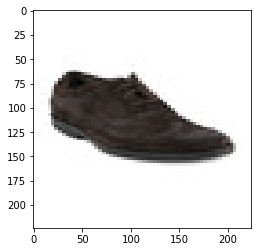

image loaded successfully!


In [18]:
# load an image in PIL format
original = load_img(root_dir + files[90], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [19]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [20]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[0.        , 0.        , 0.26583198, ..., 1.8577418 , 0.        ,
        0.        ]], dtype=float32)

In [21]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for img_id in files:
    filename = root_dir + img_id
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())


In [22]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(2000, 4096)

In [25]:
# compute cosine similarities between images

# print(len(files))
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
# cos_similarities_df.to_csv('test_cos_sim_table.csv', sep='\t', encoding='utf-8')
cos_similarities_df.head()

,56190.jpg,41679.jpg,12426.jpg,34760.jpg,44884.jpg,34268.jpg,54871.jpg,15561.jpg,58187.jpg,25372.jpg,...,9817.jpg,9497.jpg,30961.jpg,3771.jpg,25331.jpg,4163.jpg,53634.jpg,53416.jpg,13343.jpg,20404.jpg
56190.jpg,1.000000,0.487855,0.399779,0.494790,0.339070,0.303106,0.379204,0.331134,0.390468,0.337062,...,0.464009,0.450501,0.265393,0.424372,0.348216,0.475977,0.452936,0.303243,0.295324,0.380866
41679.jpg,0.487855,1.000000,0.535924,0.484291,0.428730,0.417960,0.587390,0.454630,0.420682,0.381395,...,0.692156,0.559081,0.431645,0.485018,0.472666,0.549208,0.695875,0.409096,0.332692,0.372764
12426.jpg,0.399779,0.535924,1.000000,0.432363,0.401493,0.394722,0.399862,0.410850,0.500922,0.428956,...,0.648107,0.718235,0.426434,0.433379,0.506213,0.705022,0.592878,0.346907,0.503590,0.455055
34760.jpg,0.494790,0.484291,0.432363,1.000000,0.339028,0.344798,0.428119,0.356010,0.573763,0.305562,...,0.410000,0.413855,0.346246,0.452015,0.350903,0.543523,0.383439,0.304541,0.468311,0.462246
44884.jpg,0.339070,0.428730,0.401493,0.339028,1.000000,0.571442,0.385211,0.458942,0.310887,0.719263,...,0.441498,0.425244,0.577096,0.669681,0.440045,0.390831,0.368181,0.679339,0.416633,0.265565


In [29]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):
    
    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(root_dir+given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(root_dir + closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


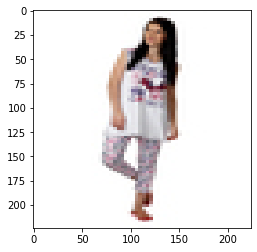

-----------------------------------------------------------------------
most similar products:


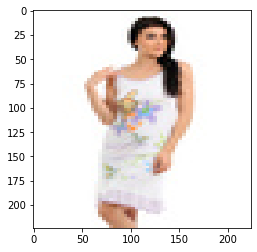

similarity score :  0.81899714


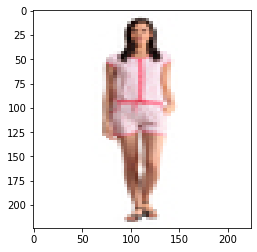

similarity score :  0.8071083


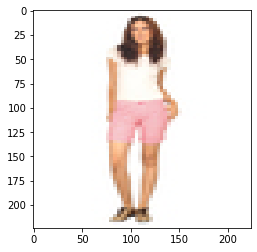

similarity score :  0.7917312


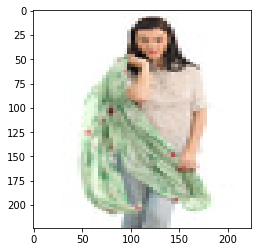

similarity score :  0.7906356


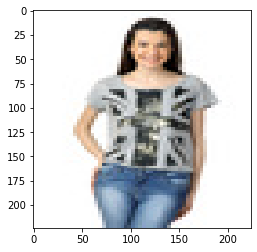

similarity score :  0.7869004



In [36]:
retrieve_most_similar_products(files[150])
print()